# Random Forest Classification

#### Random Forest is a good choice for a model because it's robust to overfitting and sklearn has specific settings to help with class balance

- Load the pipeline:
- Create an initial model
- Compare with SMOTE on the training set.
- Fine Tuning
    - n_estimators: number of trees
    - max_depth: tree depth (controls overfitting)
    - max_features: features considered at each split
    - class_weight: try balanced vs None
    - Metric: Gini vs Entropy
Metric: F1 weighted for gridsearch and classigication report + ROC AUC on the test

### Load the pipeline

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cluster_log_transform import Cluster_Log # This is our handmade function!
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from imblearn.over_sampling import SMOTE



from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Display setting set to view whole notebook end to end
pd.set_option('display.max_columns',100)

Preliminary prep from Andres

In [8]:
# Importing data
raw_data = pd.read_csv("online_shoppers_intention.csv")

# Converting certain numerical columns to categorical
num_to_cat_cols = ["OperatingSystems", "Browser", "Region", "TrafficType"]
raw_data[num_to_cat_cols] = raw_data[num_to_cat_cols].astype("category")

# Print original shape, drop duplicates, and print shape to verify
print(raw_data.shape)
clean_data = raw_data.drop_duplicates().reset_index(drop = True)
print(clean_data.shape)

# Creating a list of the categorical features to create dummy variables and add them to X
cat_cols = ["Month", "OperatingSystems", "Browser", "Region", 
            "TrafficType", "VisitorType", "Weekend"]
dummy_cols = pd.get_dummies(clean_data[cat_cols])

# Separating clean data into X and Y
X = clean_data.iloc[:,:-1]
Y = clean_data.iloc[:,-1]

# Getting rid of cat cols and replacing them with dummy cols
X = pd.concat([X.drop(columns=cat_cols), dummy_cols.astype(int)], axis=1)

# Cluster_Log requires the names of the numerical columns
num_df = clean_data.select_dtypes(include=["int64", "float64"])
num_cols = num_df.columns

# Creating preprocessor using ColumnTransformer
preprocessor = ColumnTransformer([("add_clusters_and_log", Cluster_Log(k = 5), num_cols)],
                                remainder = "passthrough")

(12330, 18)
(12205, 18)


### Creating the initial model and testing it

In [9]:
# Creating pipeline
forest_pipe = Pipeline(steps = [
    ("preprocessing",preprocessor),
    ("classifier",RandomForestClassifier())
])

# Train test split ('stratify = Y' and 'shuffle = True' due to class imbalance)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = Y, test_size=0.2, random_state= 88, shuffle=True)

# Fitting model
init_model = forest_pipe.fit(X_train, Y_train)

Initial Random Forest Classifier F1 Score: 0.89

Initial Random Forest Classifier Report
                  precision    recall  f1-score   support

No Purchase Made       0.92      0.97      0.94      2059
   Purchase Made       0.78      0.53      0.63       382

        accuracy                           0.90      2441
       macro avg       0.85      0.75      0.79      2441
    weighted avg       0.90      0.90      0.89      2441


Initial Random Forest Classifier AUC Score: 0.93


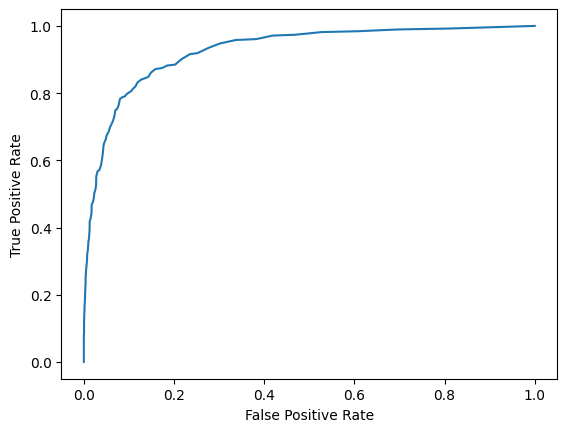

In [10]:
# Predictions and probabilities
y_pred = init_model.predict(X_test)
y_proba = init_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
init_f1 = f1_score(Y_test, y_pred, average = "weighted")
print(f"Initial Random Forest Classifier F1 Score: {init_f1:.2f}")
print()

# Classification Report
class_names = ["No Purchase Made", "Purchase Made"]
print("Initial Random Forest Classifier Report")
print(classification_report(Y_test, y_pred, target_names = class_names))
print()

# Simple function to plot the ROC curve
def plot_roc_curve(y_true, y_prob):
    """
    Plots the ROC curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(Y_test, y_proba)
print(f'Initial Random Forest Classifier AUC Score: {roc_auc_score(Y_test, y_proba):.2f}')

While the number of correctly identified purchased / not purchased were decently high, the model struggled significantly with finding the correct number of purchases made. The f1 confirms that the model is strong  when a purchase is not made whereas the model cannot accurately measure if a purchase would be made or not.

This struggle is most likely due to the class imbalance as the Purchases make up only 18% of the data. We can use smote to balance the dataset.

### SMOTE

In [11]:
# Create SMOTE object
smote = SMOTE(random_state = 88, sampling_strategy = 0.6) # Make minority 60% of majority
X_train_res, Y_train_res = smote.fit_resample(X_train, Y_train)

# Fitting model
forest_smote_model = forest_pipe.fit(X_train_res, Y_train_res)

print(f'Y Before:\n{Y_train.value_counts()}\nY After:\n{Y_train_res.value_counts()}')

Y Before:
Revenue
False    8238
True     1526
Name: count, dtype: int64
Y After:
Revenue
False    8238
True     4942
Name: count, dtype: int64


Forest (with SMOTE) Weighted F1 Score: 0.90

Forest (with SMOTE) Classification Report
                  precision    recall  f1-score   support

No Purchase Made       0.93      0.96      0.94      2059
   Purchase Made       0.73      0.62      0.67       382

        accuracy                           0.90      2441
       macro avg       0.83      0.79      0.81      2441
    weighted avg       0.90      0.90      0.90      2441


Forest (with SMOTE) AUC Score: 0.93


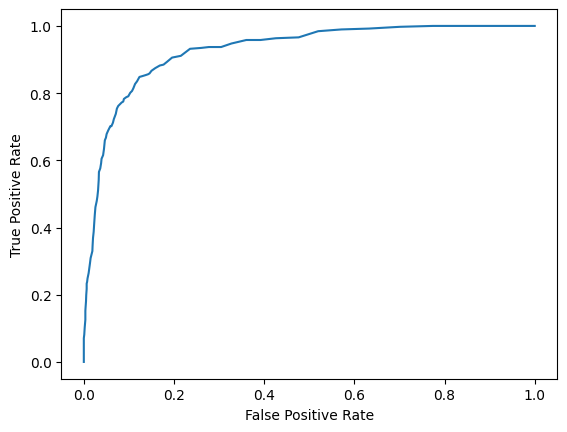

In [12]:
# Predictions and probabilities
y_pred_smote = forest_smote_model.predict(X_test)
y_proba_smote = forest_smote_model.predict_proba(X_test)[:,1]

# Weighted F1 Score
forest_smote_f1 = f1_score(Y_test, y_pred_smote, average = "weighted")
print(f"Forest (with SMOTE) Weighted F1 Score: {forest_smote_f1:.2f}")
print()

# Classification Report
class_names = ["No Purchase Made", "Purchase Made"]
print("Forest (with SMOTE) Classification Report")
print(classification_report(Y_test, y_pred_smote, target_names = class_names))
print()
    
plot_roc_curve(Y_test, y_proba_smote)
print(f'Forest (with SMOTE) AUC Score: {roc_auc_score(Y_test, y_proba_smote):.2f}')

The SMOTE had a minor effect on the `No Purchases Made` report but moderatly improved the `Purchases Made` the ability to predict out of the total possible purchases and struggled more with identifying purchases out of the entire sample.

The change only slightly improve the total F1 score so we can identify if fine tuning will continue to improve it.

### Fine Tuning

Estimators: Checking a wide range of the amount of trees, this will slow it down but will be more thorough.

Max Depth: Checking for how deep the trees should go, checking for max depth with none as well as up to 20 or up to 10. Shorter trees can help reduce overfitting.

Max Features: Number of features in the random subset at each node. None considers all features, sqrt would consider the a random subest of the sqrt of each feature, and log2 considers a random subset of the features.

Class Weight: Automatically adjusts the weights based on the minority purchase class in proportion to its rarity.

Minimum Sample Split: Minimum samples requried for a new branch, smaller amounts allow for fine splits while larger numbers reduce overfitting.

Criterion: Measures the quality of the split. Gini vs entropy

In [15]:
param_grid_forest = {
    "classifier__n_estimators": [50,100,150,200,250,300,350,400,450,500],
    "classifier__max_depth": [None, 20, 10],
    "classifier__max_features": [None,"sqrt"],
    "classifier__class_weight": [None, "balanced","balanced_subsample"],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__criterion": ["gini","entropy"]
}

kf = KFold(n_splits=5, shuffle=True, random_state=88)

forest_grid = GridSearchCV(
    estimator=forest_pipe,
    param_grid=param_grid_forest,
    cv=kf,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=1
)

'''Ensuring we are not using SMOTE variables for this because we are testing if sklearn's 
balancing will improve it.'''

forest_grid.fit(X_train, Y_train)

print("Best params:", forest_grid.best_params_)
print(f"Best CV weighted F1: {forest_grid.best_score_:.3f}")

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best params: {'classifier__class_weight': None, 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV weighted F1: 0.898


### The Best Parameters for each one:
Estimators: 200 - moderate amount of trees, indicating a larger forest doesn't have any meaningfull improvements when cross-validated with the weighted F1.

Max Depth: 10 - Best with ten branches on each tree. Still limits overfitting compared to fully grown (no max depth) trees.

Max Features: None - Best when considering all the features.

Class Weight: None - Indicates that the random forest is balanced enough that the classes did not need any adjustments. This is slightly hinted at with SMOTE only slightly improving the results.

Minimum Sample Split: 5 - ensuring the branches don't get too small by having at least five samples before a split.

Criterion: Entropy was a better measure of the spilt quality than gini as entropy is more sentsitive to changes in small probabilities, the default is gini which could be why we were able to use more conservative estimators and depth.

Best CV weighted F1: 0.898
The tuned Random Forest achieved a best cross-validated weighted F1-score of 0.898, indicating strong overall performance across both classes while accounting for the larger proportion of non-purchase sessions.

#### Fitted Model

Tuned RF weighted F1: 0.901

Classification report (tuned RF):

              precision    recall  f1-score   support

 No Purchase       0.93      0.96      0.94      2059
    Purchase       0.74      0.60      0.66       382

    accuracy                           0.90      2441
   macro avg       0.84      0.78      0.80      2441
weighted avg       0.90      0.90      0.90      2441



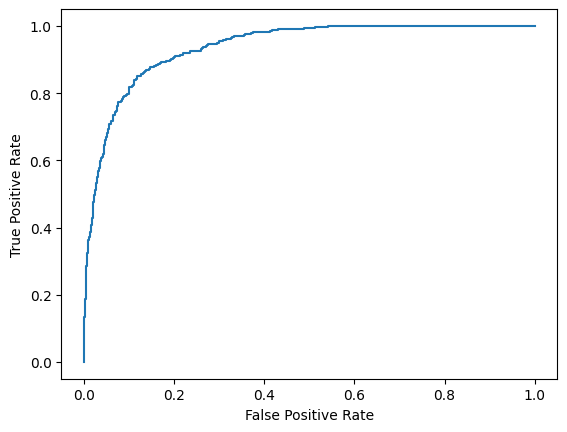

Tuned RF ROC AUC: 0.937


In [16]:
best_rf = forest_grid.best_estimator_

y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Tuned RF weighted F1: {f1_score(Y_test, y_pred_best, average='weighted'):.3f}")
print("\nClassification report (tuned RF):\n")
print(classification_report(Y_test, y_pred_best, target_names=["No Purchase", "Purchase"]))

plot_roc_curve(Y_test, y_proba_best)
plt.show()

print(f"Tuned RF ROC AUC: {roc_auc_score(Y_test, y_proba_best):.3f}")

Even after tuning, the improvement over the SMOTE model is less than 1% the weighted average and the tuned model had a less than 1% improvement for the ROC AUC. The `No Purchases` precision and recall are identical for both models and the `No Purchases` predictions were highly reliable while the `Purchase` sessions predictability were more modest with an f1 of 0.66-0.67 between the two models. 

The Random Forest model would be best utilized for predicting when a session would result in nothing purchased, and if implemented live, could be part of the trigger for showing large discounts earlier or help align targetting emails instead of cold emailing everyone.

### Confusion Matrix
For visualization

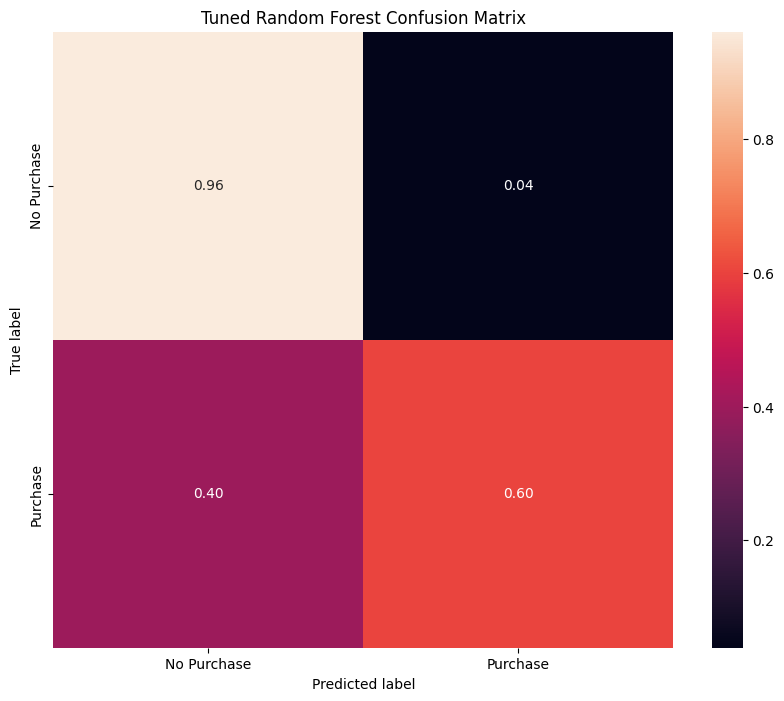

In [20]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(Y_test, y_pred_best)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis] #Got from a medium article

labels = ["No Purchase", "Purchase"]

plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt=".2f",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Tuned Random Forest Confusion Matrix")
plt.show()